<a href="https://colab.research.google.com/github/bmil-ssu/advanced_ann/blob/main/2_Unsupervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from sklearn.model_selection import train_test_split

from tqdm import tqdm
import matplotlib.pyplot as plt

import numpy as np

In [22]:
# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 5e-4

ENCODER_1 = 256
ENCODER_2 = 128
ENCODER_3 = 64
ENCODER_4 = 16

LATENT_VECTOR = 4

DECODER_1 = 16
DECODER_2 = 64
DECODER_3 = 128
DECODER_4 = 256

# 학습에 사용할 CPU나 GPU, MPS 장치를 얻습니다.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [23]:
# 공개 데이터셋에서 학습 데이터를 내려받습니다.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

view_data = training_data.data[:5].view(-1,28*28)
view_data = view_data.type(torch.FloatTensor)/255.

# 학습 데이터를 학습/검증 데이터로 분리합니다.
training_data, validation_data = train_test_split(training_data, test_size=10000)

# 공개 데이터셋에서 테스트 데이터를 내려받습니다.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [24]:
# 데이터로더를 생성합니다.
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE)
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

# 데이터의 형태를 확인합니다.
for X, y in test_dataloader:
    input_shape = X.shape[2] * X.shape[3]
    print(f"Shape of input: {input_shape}")
    num_class = len(y.unique())
    print(f"num of class: {num_class}")
    break

Shape of input: 784
num of class: 10


In [25]:
# AutoEncoder 모델을 정의합니다.
class Autoencoder(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_shape,ENCODER_1),
            nn.ReLU(),
            nn.Linear(ENCODER_1, ENCODER_2),
            nn.ReLU(),
            nn.Linear(ENCODER_2, ENCODER_3),
            nn.ReLU(),
            nn.Linear(ENCODER_3, ENCODER_4),
            nn.ReLU(),
            nn.Linear(ENCODER_4, LATENT_VECTOR)
        )

        self.decoder = nn.Sequential(
            nn.Linear(LATENT_VECTOR, DECODER_1),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Linear(DECODER_1, DECODER_2),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(DECODER_2, DECODER_3),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(DECODER_3, DECODER_4),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(DECODER_4, input_shape),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = Autoencoder().to(device)
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=16, out_features=64, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=64, out_features=128, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=128, out_features=256, bias=True)
    (10

In [26]:
# 손실함수와 optimizer를 설정합니다.
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [27]:
# train 함수를 정의합니다.
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in tqdm(enumerate(dataloader)):
        X = X.view(-1,28*28).to(device)

        # 복원 오차값(=손실값)을 계산합니다.
        recon = model(X)
        loss = loss_fn(recon, X)

        # 손실값을 역전파하여 모델을 갱신합니다.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [28]:
# test 함수를 정의합니다.
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch, (X,y) in enumerate(dataloader):
            X = X.view(-1,28*28).to(device)

            recon = model(X)
            loss = loss_fn(recon, X)
            test_loss += loss
    test_loss /= num_batches
    return test_loss

In [29]:
# 학습을 진행합니다.
train_loss_list = []

val_loss_list = []

for t in range((EPOCHS)):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)

    train_loss = test(train_dataloader, model, loss_fn)

    f, a = plt.subplots(2,5,figsize=(5,2))
    print("[Epoch {}]".format(t))
    for i in range(5):
      img = np.reshape(view_data.data.numpy()[i],(28,28))
      a[0][i].imshow(img, cmap="gray")
      a[0][i].set_xticks(())
      a[0][i].set_yticks(())

    for i in range(5):
      recon = model(view_data.to(device))
      img = np.reshape(recon.data.numpy()[i],(28,28))
      a[1][i].imshow(img, cmap="gray")
      a[1][i].set_xticks(())
      a[1][i].set_yticks(())
    plt.show()

    print(f"Train Error: {train_loss:>8f} \n")
    train_loss_list.append(train_loss)

    val_loss = test(validation_dataloader, model, loss_fn)
    print(f"Validation Error: {val_loss:>8f} \n")
    val_loss_list.append(val_loss)

print("Done!")

plt.figure(figsize=(12,8))

plt.plot(train_loss_list,label="train")
plt.plot(val_loss_list,label="validation")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()

Output hidden; open in https://colab.research.google.com to view.

In [30]:
test_loss = test(test_dataloader, model, loss_fn)
print(f"Test Error: {test_loss:>8f} \n")


Test Error: 0.017214 



# Task 1: Denoising

In [31]:
def add_noise(img):
  noise = torch.randn(img.size()) * 0.3
  noisy_img = img + noise
  return noisy_img

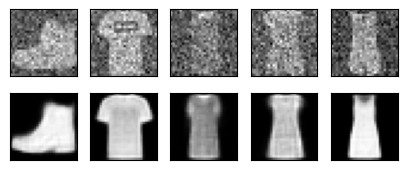

In [32]:
f, a = plt.subplots(2,5,figsize=(5,2))

for i in range(5):
  noisy_data = add_noise(view_data)
  img = np.reshape(noisy_data.data.numpy()[i],(28,28))
  a[0][i].imshow(img, cmap="gray")
  a[0][i].set_xticks(())
  a[0][i].set_yticks(())

for i in range(5):

  recon = model(noisy_data.to(device))
  img = np.reshape(recon.data.numpy()[i],(28,28))
  a[1][i].imshow(img, cmap="gray")
  a[1][i].set_xticks(())
  a[1][i].set_yticks(())
plt.show()

# Task 2: Anomaly detection

In [33]:
def anomaly_detection(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = []

    with torch.no_grad():
        for batch, (X,y) in enumerate(dataloader):
            X = X.view(-1,28*28).to(device)

            recon = model(X)
            loss = loss_fn(recon, X)
            test_loss.append(loss)
    return test_loss

In [34]:
# 학습때 경험하지 못한 MNIST 데이터를 비정상 데이터로 활용하여, anomaly detection을 진행합니다.
# 공개 데이터셋에서 테스트 데이터를 내려받습니다.
abnor_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

abnor_dataloader = DataLoader(abnor_data, batch_size=len(test_data))

view_abnor_data = abnor_data.data[:5].view(-1,28*28)
view_abnor_data = view_abnor_data.type(torch.FloatTensor)/255.

In [35]:
normal_score = anomaly_detection(test_dataloader, model, loss_fn)
abnormal_score = anomaly_detection(abnor_dataloader, model, loss_fn)

In [36]:
len(test_data)

10000

In [37]:
len(abnor_data)

10000

Text(0, 0.5, 'count')

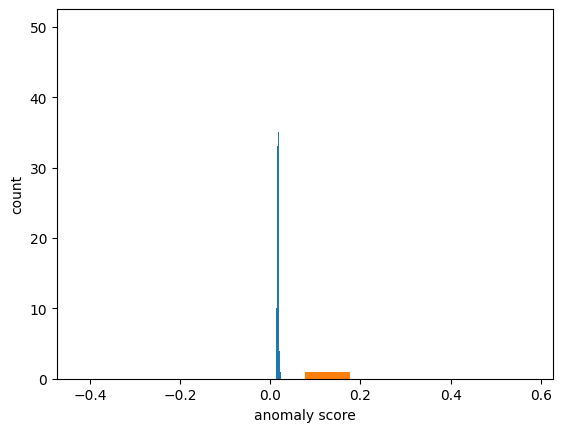

In [38]:
bins_list = []
for i in range(200):
  bins_list.append(i*0.002)
plt.hist(normal_score)
plt.hist(abnormal_score)

plt.xlabel("anomaly score")
plt.ylabel("count")

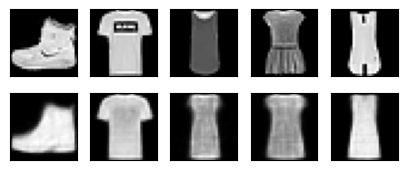

In [39]:
f, a = plt.subplots(2,5,figsize=(5,2))


for i in range(5):
  img = np.reshape(view_data.data.numpy()[i],(28,28))
  a[0][i].imshow(img, cmap="gray")
  a[0][i].set_xticks(())
  a[0][i].set_yticks(())

for i in range(5):

  recon = model(view_data.to(device))
  img = np.reshape(recon.data.numpy()[i],(28,28))
  a[1][i].imshow(img, cmap="gray")
  a[1][i].set_xticks(())
  a[1][i].set_yticks(())
plt.show()

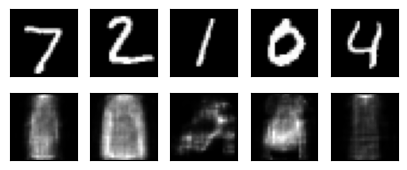

In [40]:
f, a = plt.subplots(2,5,figsize=(5,2))


for i in range(5):
  img = np.reshape(view_abnor_data.data.numpy()[i],(28,28))
  a[0][i].imshow(img, cmap="gray")
  a[0][i].set_xticks(())
  a[0][i].set_yticks(())

for i in range(5):

  recon = model(view_abnor_data.to(device))
  img = np.reshape(recon.data.numpy()[i],(28,28))
  a[1][i].imshow(img, cmap="gray")
  a[1][i].set_xticks(())
  a[1][i].set_yticks(())
plt.show()